In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from keras.models import Model
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)
# Base Libraries
from tensorflow.keras.applications import EfficientNetB0,InceptionV3,EfficientNetB3
from tensorflow.keras.models import Model
import numpy as np 
# Transformation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
# Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [6]:
train_data=os.listdir("/kaggle/input/dermnet/train")
train_data

['Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Acne and Rosacea Photos',
 'Systemic Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Vascular Tumors',
 'Urticaria Hives',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Herpes HPV and other STDs Photos',
 'Seborrheic Keratoses and other Benign Tumors',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Vasculitis Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Warts Molluscum and other Viral Infections']

In [7]:
train_list=['Light Diseases and Disorders of Pigmentation',
  'Acne and Rosacea Photos',
  'Systemic Disease',
  'Vascular Tumors',
  'Atopic Dermatitis Photos',
  'Bullous Disease Photos',
  'Tinea Ringworm Candidiasis and other Fungal Infections',
  'Psoriasis pictures Lichen Planus and related diseases',
  'Melanoma Skin Cancer Nevi and Moles',
  'Scabies Lyme Disease and other Infestations and Bites',
  'Eczema Photos',
  'Seborrheic Keratoses and other Benign Tumors',
  'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
  'Vasculitis Photos',
  'Cellulitis Impetigo and other Bacterial Infections']

In [8]:
test_list=['Light Diseases and Disorders of Pigmentation',
  'Acne and Rosacea Photos',
  'Systemic Disease',
  'Vascular Tumors',
  'Atopic Dermatitis Photos',
  'Bullous Disease Photos',
  'Tinea Ringworm Candidiasis and other Fungal Infections',
  'Psoriasis pictures Lichen Planus and related diseases',
  'Melanoma Skin Cancer Nevi and Moles',
  'Scabies Lyme Disease and other Infestations and Bites',
  'Eczema Photos',
  'Seborrheic Keratoses and other Benign Tumors',
  'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
  'Vasculitis Photos',
  'Cellulitis Impetigo and other Bacterial Infections']

In [9]:
import os
import pandas as pd

def build_image_dict(base_path, category_list):
    data_dict = {"image_path": [], "target": []}
    for target_idx, category in enumerate(category_list):
        category_path = os.path.join(base_path, category)
        if os.path.exists(category_path):
            image_files = os.listdir(category_path)
            for image in image_files:
                full_path = os.path.join(category_path, image)
                data_dict["image_path"].append(full_path)
                data_dict["target"].append(target_idx)
        else:
            print(f"Directory {category_path} not found!")
    return data_dict

def data_dictionary():
    path_train = "/kaggle/input/dermnet/train/"
    path_test = "/kaggle/input/dermnet/test/"

    train_dict = build_image_dict(path_train, train_list)
    test_dict = build_image_dict(path_test, test_list)

    # Convert to DataFrames
    train_df = pd.DataFrame(train_dict)
    test_df = pd.DataFrame(test_dict)

    return train_df, test_df
    

In [10]:
train_df, test_df = data_dictionary()
print(train_df.head())
print(test_df.head())

                                          image_path  target
0  /kaggle/input/dermnet/train/Light Diseases and...       0
1  /kaggle/input/dermnet/train/Light Diseases and...       0
2  /kaggle/input/dermnet/train/Light Diseases and...       0
3  /kaggle/input/dermnet/train/Light Diseases and...       0
4  /kaggle/input/dermnet/train/Light Diseases and...       0
                                          image_path  target
0  /kaggle/input/dermnet/test/Light Diseases and ...       0
1  /kaggle/input/dermnet/test/Light Diseases and ...       0
2  /kaggle/input/dermnet/test/Light Diseases and ...       0
3  /kaggle/input/dermnet/test/Light Diseases and ...       0
4  /kaggle/input/dermnet/test/Light Diseases and ...       0


In [11]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11491 entries, 0 to 11490
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  11491 non-null  object
 1   target      11491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 179.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2983 entries, 0 to 2982
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2983 non-null   object
 1   target      2983 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.7+ KB


In [13]:
#train data

import cv2
images = []
labels = []

for i in train_df['image_path']:
    img = cv2.imread(i)
    if img is not None:
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
        except Exception as e:
            print(f"Error processing image {i}: {e}")
    else:
        print(f"Skipped: {i} (could not load)")

# convert to NumPy only if all images are valid and same shape
data = np.array(images)

print("Shape of data:", data.shape)  

Shape of data: (11491, 224, 224, 3)


In [14]:
# test data 

import cv2
test_images = []
labels = []

for i in test_df['image_path']:
    img = cv2.imread(i)
    if img is not None:
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            test_images.append(img)
        except Exception as e:
            print(f"Error processing image {i}: {e}")
    else:
        print(f"Skipped: {i} (could not load)")

# convert to NumPy only if all images are valid and same shape
data_test = np.array(test_images)

print("Shape of data:", data_test.shape)  


Shape of data: (2983, 224, 224, 3)


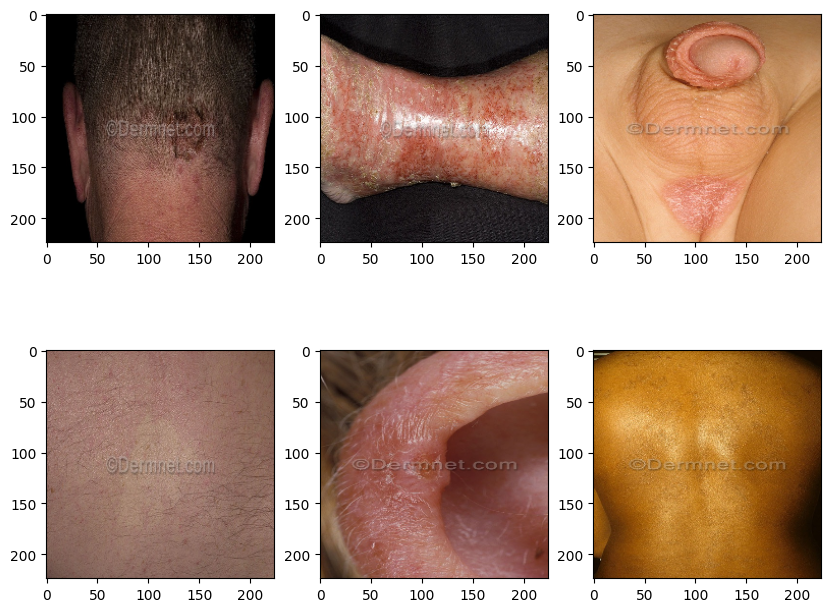

In [15]:
# list of example inputs
example_list = [image for image in random.sample(images, k=6)]

# images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for ax, img_array in zip(axes.ravel(), example_list):
    ax.imshow(img_array)

plt.show()

In [16]:
label=train_df['target']
label=np.array(label)
label.shape

(11491,)

In [17]:
test_label=test_df['target']
test_label=np.array(test_label)
test_label.shape

(2983,)

In [18]:
data.shape

(11491, 224, 224, 3)

In [19]:
data_test.shape

(2983, 224, 224, 3)

In [20]:
!pip install sklearn_relief

In [21]:
from tensorflow.keras.applications import EfficientNetB0 
from tensorflow.keras.utils import plot_model

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False
# model structure
base_model.summary()

I0000 00:00:1755964911.470704      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755964911.471446      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [22]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Save the best model based on validation accuracy
mcp_save = ModelCheckpoint(
    'EfficientNetB0_SkinDisease.keras', 
    save_best_only=True,
    monitor='val_accuracy', 
    mode='max',              # reacts when accuracy higher
    verbose=1
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',   
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max',               
    min_lr=1e-6              # threshold learning rate
)


In [23]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# fullyconnected neural network with 3 layers
def build_classifier(input_dim):
    model = Sequential([
        Dense(200, activation='relu', input_shape=(input_dim,)),
        Dense(170, activation='relu'),
        Dense(15, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Stratified K-Fold
y_int = label  # label is 1D integer array
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

fold = 1
acc = []

for train_index, val_index in skf.split(data, y_int):
    print(f"\n Fold {fold}")

    # Split image and label data
    x_train, x_val = data[train_index], data[val_index]
    y_train = to_categorical(label[train_index], num_classes=15)
    y_val = to_categorical(label[val_index], num_classes=15)

    # Preprocess images for EfficientNet
    x_train = preprocess_input(x_train)
    x_val = preprocess_input(x_val)

    # Extract features from EfficientNet
    features_train = base_model.predict(x_train, verbose=0)
    features_val = base_model.predict(x_val, verbose=0)

    # Flatten features 4D to 2D (no. of images and features)
    x_train_flat = features_train.reshape(len(x_train), -1)
    x_val_flat = features_val.reshape(len(x_val), -1)

    # Train classifier
    model = build_classifier(x_train_flat.shape[1])
    model.fit(x_train_flat, y_train, epochs=15, batch_size=32, verbose=1) # update weights batch of 32 

    # Evaluate on validation data
    val_loss, val_acc = model.evaluate(x_val_flat, y_val, verbose=0)
    acc.append(val_acc)
    print(f"Fold {fold} Accuracy: {val_acc:.4f}")

    import gc
    del x_train, x_val, y_train, y_val
    del features_train, features_val, x_train_flat, x_val_flat
    gc.collect()

    fold += 1

# Final Result
print(f"\n Average Accuracy over 7 folds: {np.mean(acc):.4f}")



 Fold 1


I0000 00:00:1755964942.228923     127 service.cc:148] XLA service 0x7bc26008a210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755964942.229595     127 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755964942.229615     127 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755964942.904454     127 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755964948.235322     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2611 - loss: 2.8764
Epoch 2/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5090 - loss: 1.5533
Epoch 3/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6914 - loss: 0.9734
Epoch 4/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8203 - loss: 0.5625
Epoch 5/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9007 - loss: 0.3326
Epoch 6/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9236 - loss: 0.2498
Epoch 7/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9484 - loss: 0.1876
Epoch 8/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9488 - loss: 0.1739
Epoch 9/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9314 - loss: 0.2357
Epoch 10/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9378 - loss: 0.2193
Epoch 11/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9501 - loss: 0.2002
Epoch 12/15
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/ste

In [25]:
import os, cv2, gc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

def extract_flat_features(df, feature_file, label_file,
                          batch_size=32, image_size=(224, 224)):
    if os.path.exists(feature_file) and os.path.exists(label_file):
        print(f"Loading cached features from {feature_file}")
        X_flat = np.load(feature_file)
        y_onehot = np.load(label_file)
        return X_flat, y_onehot

    enet = EfficientNetB0(weights='imagenet',
                          include_top=False,
                          input_shape=(*image_size, 3))
    enet.trainable = False

    features, labels = [], []
    img_paths  = df['image_path'].tolist()
    targets    = df['target'].tolist()

    for start in range(0, len(img_paths), batch_size):
        end   = min(start + batch_size, len(img_paths))
        paths = img_paths[start:end]
        labs  = targets[start:end]

        imgs  = []
        for p in paths:
            img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
            imgs.append(cv2.resize(img, image_size))
        imgs = preprocess_input(np.array(imgs, dtype='float32'))

        feat = enet.predict(imgs, verbose=0)
        features.append(feat)
        labels.extend(labs)

        # release memory of imgs
        del imgs, feat
        gc.collect()

    X = np.vstack(features)
    X_flat = X.reshape(X.shape[0], -1)
    y_onehot = tf.keras.utils.to_categorical(labels, num_classes=15)

    np.save(feature_file, X_flat)
    np.save(label_file,  y_onehot)
    print(f"Saved features to {feature_file}")
    return X_flat, y_onehot

TRAIN_FEAT = "enet_train_features.npy"
TRAIN_LABEL= "enet_train_labels.npy"
TEST_FEAT  = "enet_test_features.npy"
TEST_LABEL = "enet_test_labels.npy"

# train_df  : columns ['image_path', 'target']
# test_df   : columns ['image_path', 'target']

X_train_all, y_train_all = extract_flat_features(train_df, TRAIN_FEAT, TRAIN_LABEL)
X_test,      y_test      = extract_flat_features(test_df,  TEST_FEAT,  TEST_LABEL)

x_tr, x_val, y_tr, y_val = train_test_split(
    X_train_all,
    y_train_all,
    test_size=0.1,
    random_state=42,
    stratify=np.argmax(y_train_all, axis=1)
)

def build_classifier(input_dim):
    model = Sequential([
        Dense(1024, activation='relu',
              input_shape=(input_dim,),
              kernel_regularizer=regularizers.l2(1e-3)),
        Dropout(0.5),
        Dense(512,  activation='relu',
              kernel_regularizer=regularizers.l2(1e-3)),
        Dropout(0.3),
        Dense(15, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_classifier(X_train_all.shape[1])

reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',
                               factor=0.5, patience=5,
                               min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True)

history = model.fit(
    x_tr, y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Final test accuracy: {test_acc:.4f}")


Loading cached features from enet_train_features.npy
Loading cached features from enet_test_features.npy


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.1868 - loss: 7.1374 - val_accuracy: 0.3052 - val_loss: 4.9086 - learning_rate: 5.0000e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2894 - loss: 4.9456 - val_accuracy: 0.3426 - val_loss: 4.4706 - learning_rate: 5.0000e-04
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3565 - loss: 4.4152 - val_accuracy: 0.3461 - val_loss: 4.1454 - learning_rate: 5.0000e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3972 - loss: 4.0151 - val_accuracy: 0.3826 - val_loss: 3.9090 - learning_rate: 5.0000e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4223 - loss: 3.7425 - val_accuracy: 0.3983 - val_loss: 3.8086 - learning_rate: 5.0000e-04
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4638 - loss: 3.5747 - val_accuracy: 0.4209 - val_loss: 3.6928 - learning_rate: 5.0000e-04
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/st

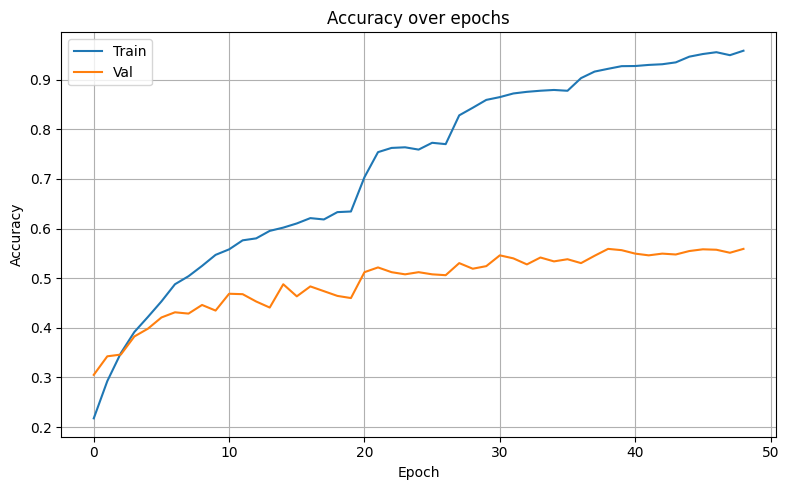

In [26]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'],     label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("train_val_accuracy.png", dpi=150)
plt.show()

model.save_weights("efficientnet_dense.weights.h5")   # lightweight


In [27]:
final_train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")

Final Training Accuracy: 0.9585


Confusion matrix (rows = true, cols = predicted):
 [[ 57  10   7   1   8   0   5  21   2   2   8   8   9   3   2]
 [  7 283   3   0   1   0   5   2   2   0   0   7   2   0   0]
 [ 11   9  65   1   5   0   5   9   0   4   7  16  11   8   1]
 [  3   3   2  43   8   1   5   8   1   2   3  20  20   2   0]
 [  5   9   6   3  55   1   9  11   0   4  15   3   0   2   0]
 [  1   0  14   5   0  34   7  16   0   1   6  16  10   3   0]
 [  8  16   7   3   4   4 193  36   2   3  16  11  17   0   5]
 [ 10   7   9   2  11   7  33 187   1   0  32  25  23   3   2]
 [  2   3   5   1   5   0   4   0  52   1   0  31  12   0   0]
 [  5   3   6   2   8   0   4  14   4  38   6   8   6   3   1]
 [  4   3   7   0   9   3  25  38   1   3 176  16  18   3   3]
 [ 11  14  15   3   2   2   9  12  15   1  10 218  29   2   0]
 [  3  10   3   3   1   3   7  11   3   1   8  31 201   1   2]
 [  4   2   4   2   6   2   4  15   0   1  10   2   3  49   1]
 [  3   5   2   0   5   2  10   7   0   0   7   4   8   3  17]]

Cl

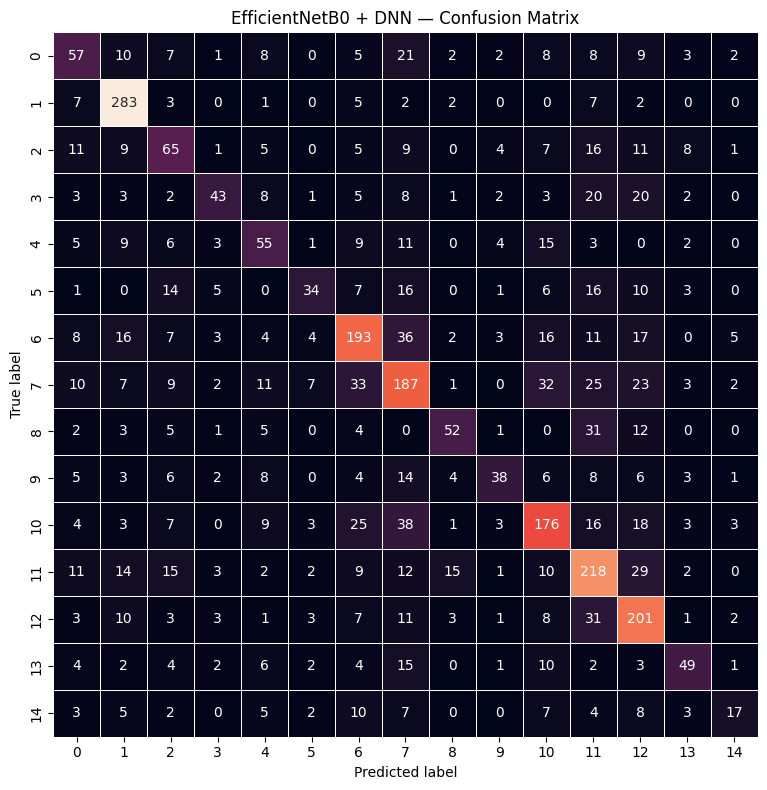

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict class labels for the test set
y_prob = model.predict(X_test, verbose=0)        # shape (n_samples, 15)
y_pred = np.argmax(y_prob, axis=1)               # predicted class indices
y_true = np.argmax(y_test, axis=1)               # ground-truth class indices

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows = true, cols = predicted):\n", cm)
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

# heat map
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm,
            annot=True, fmt='d', linewidths=0.5,
            cbar=False, square=True,
            ax=ax)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('EfficientNetB0 + DNN — Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=150)
plt.show()


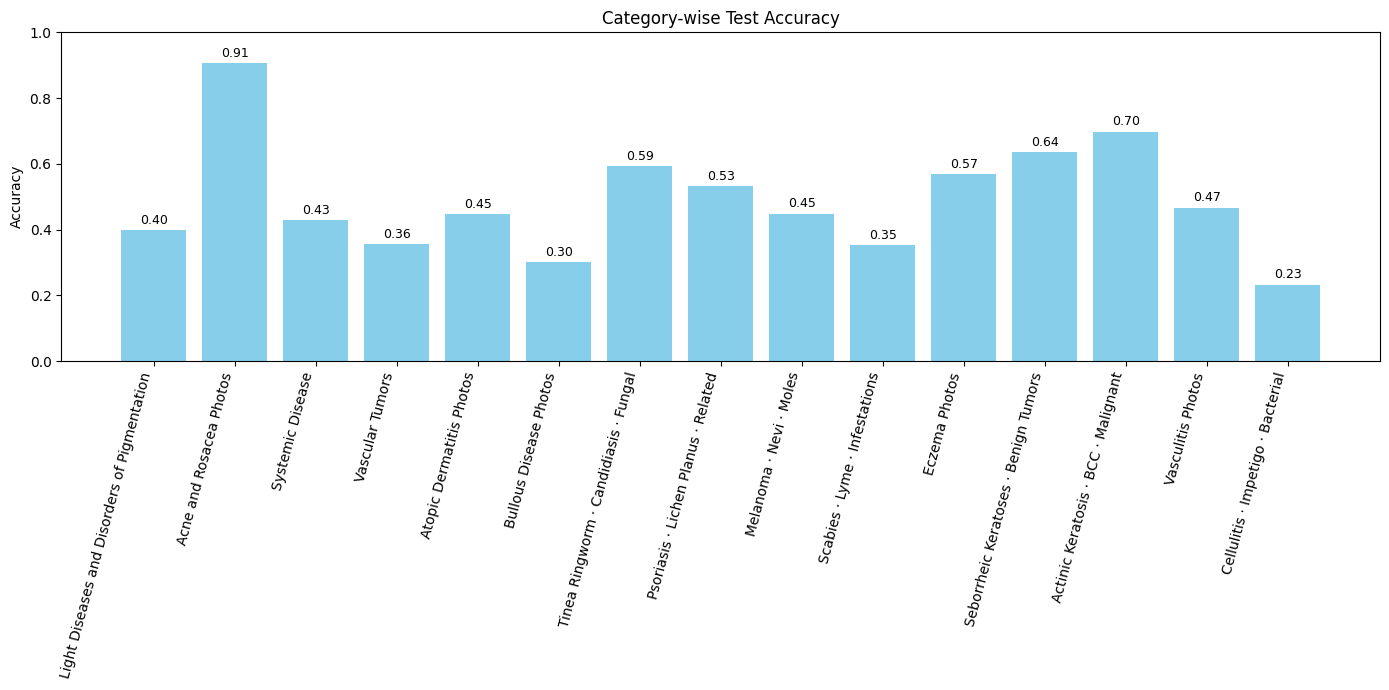

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Class names
CLASS_NAMES = [
    'Light Diseases and Disorders of Pigmentation',
    'Acne and Rosacea Photos',
    'Systemic Disease',
    'Vascular Tumors',
    'Atopic Dermatitis Photos',
    'Bullous Disease Photos',
    'Tinea Ringworm · Candidiasis · Fungal',
    'Psoriasis · Lichen Planus · Related',
    'Melanoma · Nevi · Moles',
    'Scabies · Lyme · Infestations',
    'Eczema Photos',
    'Seborrheic Keratoses · Benign Tumors',
    'Actinic Keratosis · BCC · Malignant',
    'Vasculitis Photos',
    'Cellulitis · Impetigo · Bacterial'
]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Category-wise accuracy: diagonal / row sum
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Bar plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(range(len(class_wise_accuracy)), class_wise_accuracy, color="skyblue")

# X-axis labels with class names
ax.set_xticks(range(len(class_wise_accuracy)))
ax.set_xticklabels(CLASS_NAMES, rotation=75, ha="right")

ax.set_ylim(0, 1)
ax.set_ylabel("Accuracy")
ax.set_title("Category-wise Test Accuracy")

# Annotate bars with accuracy values
for bar, acc in zip(bars, class_wise_accuracy):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{acc:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("category_wise_accuracy.png", dpi=150)  # Save the image
plt.show()


In [30]:
model.save("final_skin_model.keras")   


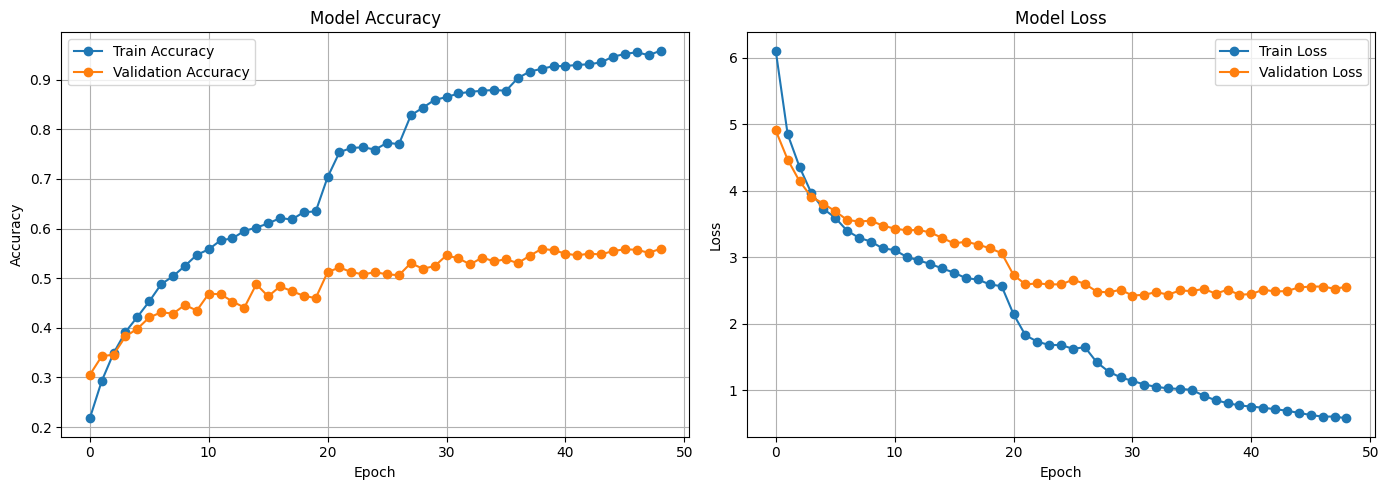

In [31]:
import matplotlib.pyplot as plt

# Assuming you stored the training history from model.fit() in 'history'
# Example: history = model.fit(...)

# Plot training & validation accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss
ax[1].plot(history.history['loss'], label='Train Loss', marker='o')
ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.savefig("training_accuracy_loss.png", dpi=150)  # Save the image
plt.show()


In [32]:
# Frozen EfficientNetB0 feature extractor
_enet_extractor = EfficientNetB0(weights='imagenet',
                                 include_top=False,
                                 input_shape=(224, 224, 3))
_enet_extractor.trainable = False    

# trained dense classifier saved earlier
_classifier = tf.keras.models.load_model('final_skin_model.keras')

_CLASS_NAMES = [
    'Light Diseases and Disorders of Pigmentation',
    'Acne and Rosacea Photos',
    'Systemic Disease',
    'Vascular Tumors',
    'Atopic Dermatitis Photos',
    'Bullous Disease Photos',
    'Tinea Ringworm · Candidiasis · Fungal',
    'Psoriasis · Lichen Planus · Related',
    'Melanoma · Nevi · Moles',
    'Scabies · Lyme · Infestations',
    'Eczema Photos',
    'Seborrheic Keratoses · Benign Tumors',
    'Actinic Keratosis · BCC · Malignant',
    'Vasculitis Photos',
    'Cellulitis · Impetigo · Bacterial'
]
def predict_skin_disease(image_path):
    # Load & preprocess 
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img.astype('float32'))
    img = np.expand_dims(img, 0)            # shape (1, 224, 224, 3)

    # Extract EfficientNet features & flatten
    feat = _enet_extractor.predict(img, verbose=0)   # (1, 7, 7, 1280)
    feat = feat.reshape(1, -1)                       # (1, 62720)

    # Classify with the dense network
    probs = _classifier.predict(feat, verbose=0)[0]  # (15,)
    idx   = int(np.argmax(probs))

    return _CLASS_NAMES[idx]


In [33]:
print(predict_skin_disease("/kaggle/input/dermnet/test/Acne and Rosacea Photos/07RosaceaFulFAce.jpg"))

Acne and Rosacea Photos


In [34]:
print(predict_skin_disease("/kaggle/input/dermnet/test/Eczema Photos/03DermatitisArm1.jpg"))

Eczema Photos
